In [1]:
# make sure you don't hog all the video memory
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)
###################################

from keras.layers import Input, Lambda, merge, Dense, DepthwiseConv2D, Activation, AveragePooling2D
from keras.layers import Flatten,Conv2D, MaxPooling2D, Dropout, BatchNormalization, SeparableConv2D
from keras.constraints import max_norm
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.initializers import RandomUniform
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
import numpy.random as rng
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
# import seaborn as sns
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [2]:
SHUFFLE = False
Seed = 4
SCRAMBLE_FOR_TEST = False
AUGMENT = True

file = 'Merged456-197-289_ICA(-eyes)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-93.mat' #0.75(vanilla EEGnet), 0. (SiameseL1)
# file = 'Merged456-1-94_ICA(-2,3ICs)+AUDpreproc.mat, DS2=64Hz, FIR=2-30Hz, centnorm=1, step=2, win=2, TD, 1-95.mat' #0.61(vanilla EEGnet)
# get the Dataset:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

path = '/home/amplifier/home/DATASETS/' + file
mat_contents = sio.loadmat(path)
X = mat_contents['X']
Y = mat_contents['Z']

if X.shape[1]<X.shape[2]:
    X = np.transpose(X,[0,2,1])

if Y.shape[1] > Y.shape[0]:
    Y = Y.T

    
# # one hot encode the labels:
# onehot_encoder = preprocessing.OneHotEncoder(sparse=False)
# Y = onehot_encoder.fit_transform(Y)

X = X.transpose(0,2,1)

print('Original data shape:', X.shape)
print('Original labels shape:', Y.shape)


# verify that the model REALLY finds a mapping between the input and the labels. If we get
# our accuracy by chance, then we should get the same accuracy on a permuted dataset:
if SCRAMBLE_FOR_TEST==True:
    Y = np.random.permutation(Y)

Original data shape: (450, 60, 128)
Original labels shape: (450, 1)


In [87]:
def augment_train(X, Y, train_id, leng):
    X = X[train_id,:,:]
    Y = Y[train_id]

    id1 = np.random.choice(range(len(X)), size=leng,  replace=True)
    id2 = np.random.choice(range(len(X)), size=leng,  replace=True)
    XX = [X[id1,:,:], X[id2,:,:]]
    YY = [Y[id1],Y[id2]]
    targets = np.zeros(leng,)
    for i in range(leng):
        targets[i] = 1 if YY[0][i]==YY[1][i] else 0
    return XX, targets

def preproc(X,Y):
    mask = np.arange(len(X))
    mask_perm = np.random.permutation(mask)
    X2 = X[mask_perm,:,:]
    Y2 = Y[mask_perm]

    XX = [X, X2]
    YY = np.concatenate([Y,Y2], axis=1)
    targets = np.zeros(len(X),)
    for i in range(len(X)):
        targets[i] = 1 if YY[i][0]==YY[i][1] else 0
    return XX, targets

def train_test_val(X,Y, test=0.2, val=0.1, shuffle=False):
    np.random.seed(3)
    if len(X) != len(Y):
        print('SIZES ARE DIFFERENT!')
    leng = np.arange(len(X))
#     if shuffle==True:
#         leng = np.random.permutation(leng)
    x_train_id, x_val_id, y_train_id, y_val_id = train_test_split(leng, leng, test_size=val, shuffle=shuffle, random_state=10)
    x_train_id, x_test_id, y_train_id, y_test_id = train_test_split(x_train_id, y_train_id, test_size=test, shuffle=shuffle, random_state=10)
    train_id = x_train_id
    test_id = x_test_id
    val_id = x_val_id
    return train_id, test_id, val_id

# train_id, test_id, val_id = train_test_val(X,Y, 0.2, 0.1, shuffle=SHUFFLE)
# print(train_id,'\n', test_id, '\n', val_id,'\n')
# np.isin(train_id, test_id)

In [88]:
# for i in range(len(val_id)):
#     print(Y[val_id[i]], '\t', yy_val[i])

In [89]:
# print(train_id,'\n++++', test_id,'\n++++', val_id)

In [90]:
train_id, test_id, val_id = train_test_val(X,Y, 0.2, 0.1, shuffle=False)

# xx_train, yy_train = preproc(X[train_id], Y[train_id]) #############!!!!!!!!!!!!!!!!
# xx_train, yy_train = augment_train(X, Y, train_id, 1000)
# xx_test, yy_test = preproc(X[test_id], Y[test_id])
# xx_val, yy_val = preproc(X[val_id], Y[val_id])


def onehot(Y):
    temp = np.zeros([len(Y),2]) 
    for i in range(len(Y)):
        temp[i,:] = np.array([1,0]) if Y[i]==1 else np.array([0,1])
    return temp


xx_train, yy_train = X[train_id], Y[train_id]
xx_test, yy_test = X[test_id], Y[test_id]
xx_val, yy_val = X[val_id], Y[val_id]


print(yy_train.shape,yy_test.shape,yy_val.shape,)

(324, 1) (81, 1) (45, 1)


In [91]:
def get_batch(X,Y, size=10):
    a = np.random.choice(len(Y), size=size, replace=True)
    b = np.random.choice(len(Y), size=size, replace=True)
    siam_labels = (Y[a].flatten() != Y[b].flatten())*1
    return a, b, X[a], X[b], onehot(Y[a]), onehot(Y[b]), siam_labels
#     return a,b

In [ ]:
size = [90000, 2000, 100]

a_train, b_train, x_train_a, x_train_b, y_train_a, y_train_b, siam_y_train = get_batch(xx_train, yy_train, size=100000)
a_test, b_test, x_test_a, x_test_b, y_test_a, y_test_b, siam_y_test = get_batch(xx_test, yy_test, size=6500)
a_val, b_val, x_val_a, x_val_b, y_val_a, y_val_b, siam_y_val = get_batch(xx_val, yy_val, size=2000)

# diagnostics:
for i in range(len(a_val)):
    print(a_val[i],b_val[i],y_val_a[i],y_val_b[i],siam_y_val[i])

In [96]:
def EEGNet_my(input1, nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    init = RandomUniform(minval=-0.1, maxval=0.1, seed=29)
    net = Sequential()
    net.add (Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (Chans, Samples,1),
                                   use_bias = False, bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 4)))
    net.add (dropoutType(dropoutRate))
    net.add (SeparableConv2D(F2, (1, 16), use_bias = False, padding = 'same', bias_initializer=init, kernel_initializer=init))
    net.add (BatchNormalization())
    net.add (Activation('elu'))
    net.add (AveragePooling2D((1, 8)))
    net.add (dropoutType(dropoutRate))
    net.add (Flatten())
    net.add (Dense(nb_classes, kernel_constraint = max_norm(0.25), bias_initializer=init, kernel_initializer=init))
    return net

In [97]:
# def SS(x, activate=True):
#     temp = np.abs(x[0] - x[1])
#     print(x[0])
#     print(x[1])
#     print(temp)
#     out = np.dot(temp, np.array([1,1,1,1]))
#     return 1/(1+np.exp(-out)) if activate==True else out

# x = [np.array([1,2,3,5]),np.array([1,2,3,5])]
# print(SS(x, activate=True))

In [177]:
from keras.engine.topology import Layer
from keras.layers import Concatenate

# def triplet_loss(y_true, y_pred):
#     norm1 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[1]), axis=-1, keepdims=True))
#     norm2 = K.sqrt(K.sum(K.square(y_pred[0] - y_pred[2]), axis=-1, keepdims=True))
#     loss = norm1 - norm2 + 0.2
#     return loss

# input_shape = (64, 128, 1)
input_shape = xx_train[-1,:,:].shape + (1,)
# input_shape = xx_train[0][0].shape + (1,)
a_input = Input(input_shape)
r_input = Input(input_shape)

#call the convnet Sequential model on each of the input tensors so params will be shared
# encoded NOT as Sequential (stack of layers), but as a Tensor!!!! if you add an argument, a Tensor is returned
encoded_a = EEGNet_my(input_shape, 2, Chans=input_shape[0])(a_input)
encoded_r = EEGNet_my(input_shape, 2, Chans=input_shape[0])(r_input)

# class MergeLegs(Layer):
#     def __init__(self, **kwargs):
#         super(MergeLegs, self).__init__(**kwargs)

#     def call(self ,x ,mask=None):
#         a = x[0]
#         r = x[1]
#         norm1 = K.sqrt(K.sum(K.square(a - r), axis=-1, keepdims=True))
#         norm2 = K.sqrt(K.sum(K.square(a - n), axis=-1, keepdims=True))
#         loss = norm1 - norm2 + 0.5
#         self.add_loss(loss, x)
#         #you can output whatever you need, just update output_shape adequately
#         #But this is probably useful
#         return K.concatenate([a,r,n], axis=1)

#     def get_output_shape_for(self, input_shape):
#         return (input_shape[0][0],1)
    

L1_distance = Lambda(lambda tensors: (K.abs(tensors[0] - tensors[1])))([encoded_a, encoded_r])
L1_distance = Dense(1,activation='sigmoid', use_bias=True)(L1_distance)

# siamese_net = Model(inputs=[a_input, r_input], outputs=[encoded_a, encoded_r, L1_distance])
siamese_net = Model(inputs=[a_input, r_input], outputs=[L1_distance])
optimizer = Adam(0.00006)
# optimizer = 'adam'
# siamese_net.compile(loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'], optimizer=optimizer)
siamese_net.compile(loss=['binary_crossentropy'], optimizer=optimizer)
siamese_net.summary()

a1 = np.linalg.norm(siamese_net.layers[2].layers[13].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[13].get_weights()[0])
print(a1, a2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 60, 128, 1)   0                                            
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 2)            1074        input_17[0][0]                   
__________________________________________________________________________________________________
sequential_18 (Sequential)      (None, 2)            1074        input_18[0][0]                   
__________________________________________________________________________________________________
lambda_9 (

In [186]:
# Training time!
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min')
checkpointer = ModelCheckpoint(filepath='/home/amplifier/home/NEW_DL/weights/Siamese_L1_ver2.h5',
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

train_history = siamese_net.fit(x = [x_train_a[:,:,:,None], x_train_b[:,:,:,None]],
                y=[siam_y_train] ,
                epochs=10,
                batch_size=10,
                verbose=1,
                shuffle=True,
                validation_data=([x_test_a[:,:,:,None], x_test_b[:,:,:,None]], [siam_y_test]),
                callbacks=[checkpointer, early_stopping])

# model.save('/home/amplifier/home/NEW_DL/models/EEGnet.h5')

Train on 100000 samples, validate on 6500 samples
Epoch 1/10
100000/100000 [==============================] - 176s 2ms/step - loss: 0.6929 - val_loss: 0.6929

Epoch 00001: val_loss improved from inf to 0.69290, saving model to /home/amplifier/home/NEW_DL/weights/Siamese_L1_ver2.h5
Epoch 2/10
100000/100000 [==============================] - 176s 2ms/step - loss: 0.6929 - val_loss: 0.6930

Epoch 00002: val_loss did not improve from 0.69290
Epoch 3/10
100000/100000 [==============================] - 195s 2ms/step - loss: 0.6928 - val_loss: 0.6932

Epoch 00003: val_loss did not improve from 0.69290
Epoch 4/10
100000/100000 [==============================] - 273s 3ms/step - loss: 0.6926 - val_loss: 0.6931

Epoch 00004: val_loss did not improve from 0.69290
Epoch 5/10
100000/100000 [==============================] - 176s 2ms/step - loss: 0.6923 - val_loss: 0.6932

Epoch 00005: val_loss did not improve from 0.69290
Epoch 6/10
100000/100000 [==============================] - 176s 2ms/step - lo

In [190]:
siamese_net.load_weights('/home/amplifier/home/NEW_DL/weights/Siamese_L1_ver2.h5')

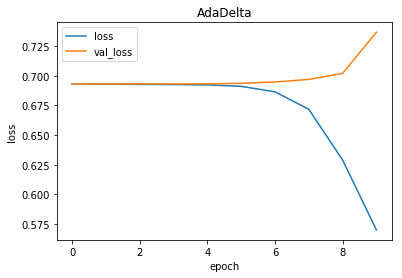

In [191]:
# print(np.array(history.losses))
import matplotlib.pyplot as plt
%matplotlib inline
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.legend(['loss', 'val_loss'])
plt.title('AdaDelta')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [192]:
a1 = np.linalg.norm(siamese_net.layers[2].layers[13].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[13].get_weights()[0])
print(a1, a2)

0.35199335 0.34024575


In [189]:
pred = siamese_net.predict([x_train_a[:,:,:,None], x_train_b[:,:,:,None]])
err = siam_y_train - pred.flatten()
print('Error', np.sum(np.abs(err))/len(err))

acc = []
for i in range(len(siam_y_train)):
    if siam_y_train[i]==np.round(pred[i]):
        acc.append(1)
    else:
        acc.append(0)
print("Train acc", np.mean(acc))

Error 0.34970559469480067
Train acc 0.85792


In [193]:
pred = siamese_net.predict([x_test_a[:,:,:,None], x_test_b[:,:,:,None]])
err = siam_y_test - pred.flatten()
print('Error', np.sum(np.abs(err))/len(err))

acc = []
for i in range(len(siam_y_test)):
    if siam_y_test[i]==np.round(pred[i]):
        acc.append(1)
    else:
        acc.append(0)
print("Test Acc", np.mean(acc))

Error 0.4998481442928314
Test Acc 0.5027692307692307


In [153]:
for i in range(20):
    a = x_train_a[None,a_train[i],:,:,None]
    b = x_train_b[None,b_train[i],:,:,None]
    # b = np.random.randn(*a.shape)
    pred = siamese_net.predict([a,b])

    print(a_train[i],b_train[i],y_train_a[i],y_train_b[i],siam_y_train[i], pred)

152 208 [1. 0.] [0. 1.] 1 [[0.00483108]]
249 67 [1. 0.] [1. 0.] 0 [[0.9341727]]
131 104 [1. 0.] [1. 0.] 0 [[0.02960188]]
256 75 [0. 1.] [0. 1.] 0 [[0.02166533]]
277 106 [1. 0.] [0. 1.] 1 [[0.9300978]]
147 26 [0. 1.] [0. 1.] 0 [[0.02859868]]
202 37 [0. 1.] [1. 0.] 1 [[0.9780969]]
169 208 [0. 1.] [0. 1.] 0 [[0.00180813]]
138 283 [0. 1.] [1. 0.] 1 [[0.96969765]]
119 143 [0. 1.] [0. 1.] 0 [[0.00714612]]
148 47 [0. 1.] [0. 1.] 0 [[0.76573807]]
93 175 [1. 0.] [0. 1.] 1 [[0.919874]]
26 203 [0. 1.] [0. 1.] 0 [[0.04041896]]
150 250 [1. 0.] [1. 0.] 0 [[0.01187098]]
322 218 [0. 1.] [1. 0.] 1 [[0.8838622]]
258 6 [0. 1.] [1. 0.] 1 [[0.0279586]]
316 119 [0. 1.] [0. 1.] 0 [[0.9744778]]
129 290 [1. 0.] [0. 1.] 1 [[0.00440152]]
69 21 [1. 0.] [0. 1.] 1 [[0.00995419]]
110 11 [0. 1.] [1. 0.] 1 [[0.03733028]]


In [ ]:

# now test sample by sample
cor_test = []
L = xx_test.shape
for sample_no in range(xx_test.shape[0]):
    a = xx_test[None,sample_no,0,:,:,None]
    b = np.random.randn(*a.shape)
    y = yy_test[sample_no]
    if oneleg == False:
        pred = siamese_net.predict([a,b])[1]
    else:
        pred = siamese_net.predict([a,b])
    if ((pred[0][0]<pred[0][1]) and (y[0] < y[1])) or ((pred[0][0]>pred[0][1]) and (y[0] > y[1])):
        cor_test.append(1)
    else:
        cor_test.append(0)

cor_train = []
L = xx_train.shape
for sample_no in range(xx_train.shape[0]):
    a = xx_train[None,sample_no,0,:,:,None]
    b = np.random.randn(*a.shape)
    y = yy_train[sample_no]
    if oneleg == False:
        pred = siamese_net.predict([a,b])[1]
    else:
        pred = siamese_net.predict([a,b])
    if ((pred[0][0]<pred[0][1]) and (y[0] < y[1])) or ((pred[0][0]>pred[0][1]) and (y[0] > y[1])):
        cor_train.append(1)
    else:
        cor_train.append(0)
        
cor_val = []
L = xx_val.shape
for sample_no in range(xx_val.shape[0]):
    a = xx_val[None,sample_no,0,:,:,None]
    b = np.random.randn(*a.shape)
    y = yy_val[sample_no]
    if oneleg == False:
        pred = siamese_net.predict([a,b])[1]
    else:
        pred = siamese_net.predict([a,b])
    if ((pred[0][0]<pred[0][1]) and (y[0] < y[1])) or ((pred[0][0]>pred[0][1]) and (y[0] > y[1])):
        cor_val.append(1)
    else:
        cor_val.append(0)

# Report accuracies
print('Accuracy on the training data:', np.mean(cor_train))
print('Accuracy on the test data:', np.mean(cor_test))
print('Accuracy on the validation data:', np.mean(cor_val))

In [42]:
# The moment of truth. Check Validation accuracy (completely unseen data):
cor_val = []
for i in range (len(xx_val)):
    a = xx_val[None,i,0,:,:,None]
#     a = np.random.randn(*a.shape)

    # YOU CAN FEED INTO THE SECOND LEG ANYTHING YOU WANT,
    # THE DENSE LAYER IS CONNECTED TO LEG 1, BUT THE WEIGHTS 
    # IN LEG 1 AND LEG 2 ARE THE SAME, I.E. SHARED.
#     b = xx_val[None,i,1,:,:,None]
    b = np.random.randn(*a.shape) 
    pred = siamese_net.predict([a, b])[1]
       
    if ((pred[0][0]<pred[0][1]) and (yy_val[i][0] < yy_val[i][1]) or
       ((pred[0][0]>pred[0][1]) and (yy_val[i][0] > yy_val[i][1]))):
        cor_val.append(1)
        success = True
    else:
        cor_val.append(0)
        success = False
    
    print('Validation trial {} \t -> {:1.4f} {:1.4f} {} Correct: {}'.format (i, pred[0][0],pred[0][1], yy_val[i], success))
print('Accuracy on the VALIDATION data:', np.mean(cor_val))

Validation trial 0 	 -> 0.4927 0.4892 [ 1.  0.] Correct: True
Validation trial 1 	 -> 0.3450 0.6100 [ 0.  1.] Correct: True
Validation trial 2 	 -> 0.1880 0.7277 [ 0.  1.] Correct: True
Validation trial 3 	 -> 0.4959 0.4871 [ 0.  1.] Correct: False
Validation trial 4 	 -> 0.6038 0.4120 [ 0.  1.] Correct: False
Validation trial 5 	 -> 0.6666 0.3850 [ 1.  0.] Correct: True
Validation trial 6 	 -> 0.2217 0.6993 [ 0.  1.] Correct: True
Validation trial 7 	 -> 0.4258 0.5433 [ 0.  1.] Correct: True
Validation trial 8 	 -> 0.6632 0.3904 [ 1.  0.] Correct: True
Validation trial 9 	 -> 0.7864 0.2785 [ 1.  0.] Correct: True
Validation trial 10 	 -> 0.7415 0.3238 [ 0.  1.] Correct: False
Validation trial 11 	 -> 0.5459 0.4581 [ 1.  0.] Correct: True
Validation trial 12 	 -> 0.7882 0.2765 [ 0.  1.] Correct: False
Validation trial 13 	 -> 0.4053 0.5488 [ 0.  1.] Correct: True
Validation trial 14 	 -> 0.7553 0.3066 [ 1.  0.] Correct: True
Validation trial 15 	 -> 0.7026 0.3425 [ 0.  1.] Correct: Fal

In [805]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if np.array_equal(x, y)]

In [806]:
ind_A = get_indexes(np.array([0, 1]),yy_train)
ind_B = get_indexes(np.array([1, 0]),yy_train)
ind_A_perm = np.random.permutation(ind_A)
pred_same = np.zeros(len(ind_A))
pred_diff = np.zeros(len(ind_A))

for i in range(len(ind_A)):
    pred_diff[i] = siamese_net.predict([xx_train[None,ind_A[i],0,:,:,None],
                                        xx_train[None,ind_B[i],0,:,:,None]])

    pred_same[i] = siamese_net.predict([xx_train[None,ind_A[i],     0,:,:,None],
                                        xx_train[None,ind_A_perm[i],0,:,:,None]])

print ('Pred_diff_train', np.sum(pred_diff))
print ('Pred_same_train', np.sum(pred_same))
ind_A = get_indexes(np.array([0, 1]),yy_test)
ind_B = get_indexes(np.array([1, 0]),yy_test)
ind_A_perm = np.random.permutation(ind_A)
pred_same = np.zeros(len(ind_A))
pred_diff = np.zeros(len(ind_A))
    
for i in range(len(ind_A)):
    pred_diff[i] = siamese_net.predict([xx_test[None,ind_A[i],0,:,:,None],
                                        xx_test[None,ind_B[i],0,:,:,None]])

    pred_same[i] = siamese_net.predict([xx_test[None,ind_A[i],     0,:,:,None],
                                        xx_test[None,ind_A_perm[i],0,:,:,None]])
#     print('yy_train A', ind_A[i], yy_train[ind_A[i]], 'yy_train B', ind_B[i], yy_train[ind_B[i]], pred[i])
   
print ('Pred_diff_test', np.sum(pred_diff))
print ('Pred_same_test', np.sum(pred_same))

ValueError: setting an array element with a sequence.

In [860]:
testmod_1 = Sequential()
testmod_1.add(siamese_net.layers[0])
for i in range(14):
    testmod_1.add(siamese_net.layers[2].layers[i])
testmod_1.add(siamese_net.layers[6])
testmod_1.summary()

testmod_2 = Sequential()
testmod_2.add(siamese_net.layers[0])
for i in range(14):
    testmod_2.add(siamese_net.layers[3].layers[i])
testmod_2.add(siamese_net.layers[6])
testmod_2.summary()
    
pred_1 = testmod_1.predict(xx_train[:,0,:,:,None])
pred_2 = testmod_2.predict(xx_train[:,0,:,:,None])


# check if the weights in the siamese are really the same in all the three leg of the model:
a1 = np.linalg.norm(siamese_net.layers[2].layers[13].get_weights()[0])
a2 = np.linalg.norm(siamese_net.layers[3].layers[13].get_weights()[0])

print([siamese_net.layers[x].name for x in range(2,4)])
print([siamese_net.layers[x].layers[13].name for x in range(2,4)])
print(a1,a2)
print('\nIn the models made out the layers take from the siamese model:')
a1 = np.linalg.norm(testmod_1.layers[14].get_weights()[0])
a2 = np.linalg.norm(testmod_2.layers[14].get_weights()[0])
print(testmod_1.layers[14].name, testmod_2.layers[14].name)
print(a1,a2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 60, 128, 1)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 60, 128, 4)        256       
_________________________________________________________________
batch_normalization_217 (Bat (None, 60, 128, 4)        16        
_________________________________________________________________
depthwise_conv2d_73 (Depthwi (None, 1, 128, 8)         480       
_________________________________________________________________
batch_normalization_218 (Bat (None, 1, 128, 8)         32        
_________________________________________________________________
activation_145 (Activation)  (None, 1, 128, 8)         0         
_________________________________________________________________
average_pooling2d_145 (Avera (None, 1, 32, 8)          0         
__________

In [ ]:
labs10 = []
labs01 = []

for i in range(len(xx_train)):
    pred_1 = testmod_1.predict(xx_train[None,i,0,:,:,None])
    pred_2 = testmod_2.predict(xx_train[None,i,0,:,:,None])
    print('result:\t', i, yy_train[i], pred_1, pred_2)

In [ ]:
acc_01 = 0
for i in range(len(labs01)):
    acc_01 += np.linalg.norm(pred_1-testmod_1.predict(xx_train[None,labs01[i],:,:,None]))

acc_10 = 0
for i in range(len(labs10)):
    acc_10 += np.linalg.norm(pred_1-testmod_1.predict(xx_train[None,labs10[i],:,:,None]))

print('acc_01:', acc_01)
print('acc_10:', acc_10)

In [53]:
def EEGNet(nb_classes, Chans = 64, Samples = 128, 
             dropoutRate = 0.25, kernLength = 64, F1 = 4, 
             D = 2, F2 = 8, dropoutType = 'Dropout'):
    """ Keras Implementation of EEGNet (https://arxiv.org/abs/1611.08024)

    Inputs:
        
      nb_classes      : int, number of classes to classify
      Chans, Samples  : number of channels and time points in the EEG data
      dropoutRate     : dropout fraction
      kernLength      : length of temporal convolution in first layer. We found
                        that setting this to be half the sampling rate worked
                        well in practice. For the SMR dataset in particular
                        since the data was high-passed at 4Hz we used a kernel
                        length of 32.     
      F1, F2          : number of temporal filters (F1) and number of pointwise
                        filters (F2) to learn. Default: F1 = 4, F2 = F1 * D. 
      D               : number of spatial filters to learn within each temporal
                        convolution. Default: D = 2
      dropoutType     : Either SpatialDropout2D or Dropout, passed as a string.

    """
    
    if dropoutType == 'SpatialDropout2D':
        dropoutType = SpatialDropout2D
    elif dropoutType == 'Dropout':
        dropoutType = Dropout
    else:
        raise ValueError('dropoutType must be one of SpatialDropout2D '
                         'or Dropout, passed as a string.')
    
    input1   = Input(shape = (1, Chans, Samples))

    ##################################################################
    block1       = Conv2D(F1, (1, kernLength), padding = 'same',
                                   input_shape = (1, Chans, Samples),
                                   use_bias = False, data_format='channels_first')(input1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = DepthwiseConv2D((Chans, 1), use_bias = False, 
                                   depth_multiplier = D,
                                   depthwise_constraint = max_norm(1.), data_format='channels_first')(block1)
    block1       = BatchNormalization(axis = 1)(block1)
    block1       = Activation('elu')(block1)
    block1       = AveragePooling2D((1, 4), data_format='channels_first')(block1)
    block1       = dropoutType(dropoutRate)(block1)
    
    block2       = SeparableConv2D(F2, (1, 16),
                                   use_bias = False,
                                   padding = 'same',
                                   data_format='channels_first')(block1)
    block2       = BatchNormalization(axis = 1)(block2)
    block2       = Activation('elu')(block2)
    block2       = AveragePooling2D((1, 8), data_format='channels_first')(block2)
    block2       = dropoutType(dropoutRate)(block2)
        
    flatten      = Flatten(name = 'flatten')(block2)
    
    dense        = Dense(nb_classes, name = 'dense', 
                         kernel_constraint = max_norm(0.25))(flatten)
    softmax      = Activation('softmax', name = 'softmax')(dense)
    
    return Model(inputs=input1, outputs=softmax)

model  = EEGNet(nb_classes = 2,
                Chans = 60,
                Samples = 128,
                kernLength = 125)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 1, 60, 128)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 4, 60, 128)        500       
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 60, 128)        16        
_________________________________________________________________
depthwise_conv2d_10 (Depthwi (None, 8, 1, 128)         480       
_________________________________________________________________
batch_normalization_29 (Batc (None, 8, 1, 128)         32        
_________________________________________________________________
activation_15 (Activation)   (None, 8, 1, 128)         0         
_________________________________________________________________
average_pooling2d_14 (Averag (None, 8, 1, 32)          0         
__________

In [299]:
def TrainTestVal_Split(leng, traintest, testval):
    leng = 100
    x = np.arange(leng)
    train_id, test_id, val_id = np.split(
        x,[np.round(leng*traintest).astype(int),
           np.round(leng*testval).astype(int)])
    return train_id, test_id, val_id

# train_id, test_id, val_id = TrainTestVal_Split(100, 0.8, 0.9)
# print(train_id)
# print(test_id)
# print(val_id)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79]
[80 81 82 83 84 85 86 87 88 89]
[90 91 92 93 94 95 96 97 98 99]


In [ ]:
for j in range(xx_train.shape[0]):
    hit = []
    for i in range(X.shape[0]):
        if np.linalg.norm(X[i,:,:] - xx_train[j,0,:,:])==0:
            hit.append(i)
            print(hit)
            print('success' if np.linalg.norm(Y[i] - yy_train[j])==0 else 'FAIL!')

In [6]:
def train_augment(xx_train, yy_train):
    print('Before augmenting', xx_train.shape)
    temp_xx = np.concatenate([xx_train, xx_train, xx_train, xx_train, xx_train], axis=0)
    print(temp_xx.shape)
    temp_xx_0 = temp_xx[:,0,:,:]
    temp_xx_0 = temp_xx_0.reshape(temp_xx_0.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_0.shape)

    temp_xx_1 = temp_xx[:,1,:,:]
    np.random.shuffle(temp_xx_1)
    temp_xx_1 = temp_xx_1.reshape(temp_xx_1.shape + (1,)).transpose(0,3,1,2)
    print(temp_xx_1.shape)

    xx_train_aug = np.concatenate([temp_xx_0, temp_xx_1], axis=1)
    print('After augmenting', xx_train_aug.shape)
    print(xx_train_aug.shape)

    yy_train_aug = np.concatenate([yy_train, yy_train, yy_train, yy_train, yy_train], axis=0)
    print('yy_train_aug', yy_train_aug.shape)
    return xx_train_aug, yy_train_aug

if AUGMENT==True:
    xx_train, yy_train = train_augment(xx_train, yy_train)
    print('\nAfter augmenting:\n', xx_train.shape,'\n', yy_train.shape )

Before augmenting (324, 2, 60, 128)
(1620, 2, 60, 128)
(1620, 1, 60, 128)
(1620, 1, 60, 128)
After augmenting (1620, 2, 60, 128)
(1620, 2, 60, 128)
yy_train_aug (1620, 2)

After augmenting:
 (1620, 2, 60, 128) 
 (1620, 2)


In [4]:
a,b = [],[]
for i in range(len(X)):
    if np.array_equal(Y[i],np.array([0,1])):
        a.append(i)
    if np.array_equal(Y[i],np.array([1,0])):
        b.append(i)    

In [5]:
XX_a = np.zeros([len(a),2,X.shape[1],X.shape[2]])
XX_b = np.zeros([len(b),2,X.shape[1],X.shape[2]])
XX = np.zeros([len(a)+len(b),2,X.shape[1],X.shape[2]])

YY_a = np.zeros([len(a),2])
YY_b = np.zeros([len(b),2])
YY = np.zeros([len(b)+len(b),2])

XX_a[:,0,:,:] = X[a,:,:]
XX_a[:,1,:,:] = X[np.random.permutation(a),:,:]
YY_a = Y[a]
XX_b[:,0,:,:] = X[b,:,:]
XX_b[:,1,:,:] = X[np.random.permutation(b),:,:]
YY_b = Y[b]

XX = np.concatenate([XX_a, XX_b], axis=0)
YY = np.concatenate([YY_a, YY_b], axis=0)

print('XX_a\t', XX_a.shape)
print('XX_b\t', XX_b.shape)
print('XX\t', XX.shape)

train_id, test_id, val_id = train_test_val(XX,YY, 0.2, 0.1, shuffle=SHUFFLE)

xx_train = XX[train_id,:,:,:]
yy_train = YY[train_id]

xx_test = XX[test_id,:,:,:]
yy_test = YY[test_id]

xx_val = XX[val_id,:,:,:]
yy_val = YY[val_id]

print('\nXX_trai\t', xx_train.shape)
print('XX_test\t', xx_test.shape)
print('XX_val\t', xx_val.shape)
print('yy_trai\t', yy_train.shape)
print('yy_test\t', yy_test.shape)
print('yy_val\t', yy_val.shape)

print('\nIf you use RANDOM SEED, check if you generate the same numbers every time:')
print(train_id)
print(test_id)
print(val_id)

XX_a	 (225, 2, 60, 128)
XX_b	 (225, 2, 60, 128)
XX	 (450, 2, 60, 128)

XX_trai	 (324, 2, 60, 128)
XX_test	 (81, 2, 60, 128)
XX_val	 (45, 2, 60, 128)
yy_trai	 (324, 2)
yy_test	 (81, 2)
yy_val	 (45, 2)

If you use RANDOM SEED, check if you generate the same numbers every time:
[291 144  54 215 210 167 184 442 273  96  62 420 255  76 278  86 270 152
 122 325  48 326 264 110 436  31 410 214 361 257 357  73 407 205 115  97
 172 303 285   9 242  59 366 119 118 348 267 141  26 345 447 437 224 446
 178 189 359 245 107 262 108 330 432 272 364 250 279 346  80 388 439 206
 171  33  29 164 258 235 336  13  74  45 406 415 434 317 183 374  92 193
 208 219 428  99 225 368  51 256 342  19 394 237  44 360 132 192 315  11
 296 414 431 424 169 367   4 412 133 283  68 234 397   5 395 328 101 288
  40 165 248 112 449 307 148 308 377 157 309 338 204 320 339 127  64 221
 135 378 401  77 159 353 236 138 381  93  25 408 337 413 117 260  58 444
  79 266 306 318  47 386 227 251  72 292 380 203 387 176 179 399  5